# Netzwerk und Internet

Miteinander kommunizierende Computer sind eine sehr Erfindung.
Prominente Beispiele sind lokale Netzwerke, das Internet, das hier vorliegende IPython Notebook, Smartphones und Raumsonden.

Im folgenden wird umrissen, wie man mittels Python mit einem Server kommunizeren kann,
wie Daten übertragen werden, und wie ein Server prinzipiell gestartet werden kann.

Python selbst liefert die Bibliotheken [urllib](https://docs.python.org/2/library/urllib.html) ([Py3 urllib](https://docs.python.org/3/library/urllib.html))
und [urllib2](https://docs.python.org/2/library/urllib2.html) aus.
Sie liefern eine rudimentäre Schnittstelle um mit der Außenwelt kommunizieren zu können.

Besser ist eine Bibliothek wie [requests](http://docs.python-requests.org/en/latest/),
welche einfacher zu bedienen ist und auf diesen Bibliotheken aufbaut.
Wir importieren sie mit dem Namen `req`:

In [1]:
import requests as req

## WWW: HTTP GET requests

Kommunikation im [WWW](http://info.cern.ch/hypertext/WWW/TheProject.html) läuft über das [HTTP Protokol](http://en.wikipedia.org/wiki/HTTP) ab.
Die Sprache besteht aus Verben und Objekten.
Das Verb "GET" teilt einem anderen Computer ("Server") mit,
dass der anfragende Computer ("Client") etwas haben möchte.
Die dieser Kommunikation [zugrunde liegenden Systeme](http://en.wikipedia.org/wiki/OSI_model) stellen sicher,
dass beide miteinander auch über große Distanzen sprechen können.

Der Inhalt solch eines "Request"s kann entweder mit `.text` direkt ausgelesen werden,
oder z.B. mittels `.json()` in eine JSON Datenstruktur geparst werden.

Im folgenden Beispiel holen wir uns die Zellen des dieses hier vorliegenden Notebooks direkt vom
[Git Repository](https://github.com/haraldschilly/python-fuer-mathematiker/).
Das Dateiformat basiert auf [JSON](http://json.org) und es werden genau die hier sichtbaren Zellen geladen.

Die `requests` Bibliothek verbindet sich dabei zu GitHub über das Internet, teilt dem Server mit, dass es genau diese Datei haben möchte, und dann verarbeitet es die Rohdaten zu einer JSON Datenstruktur mittels `.json()`.
Anschließend eine kurze Suche nach dem Inhalt "vorliegenden Notebook" um genau diese Zelle zu finden und auszugeben.

In [2]:
import requests as req
netzwerk = req.get("http://github.com/haraldschilly/python-fuer-mathematiker/raw/master/doc/4-6-netzwerk.ipynb")
notebook = netzwerk.json()

/scratch/scratch/schilly/canopy/Canopy_64bit/User/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/scratch/scratch/schilly/canopy/Canopy_64bit/User/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [3]:
import json
for cell in notebook["cells"]:
    if cell["cell_type"] == "markdown":
        lines = cell["source"]
        if any("vorliegenden Notebook" in line for line in lines):
            print("".join(lines))
            break

## WWW: HTTP GET requests

Kommunikation im [WWW](http://info.cern.ch/hypertext/WWW/TheProject.html) läuft über das [HTTP Protokol](http://en.wikipedia.org/wiki/HTTP) ab.
Es gibt Verben und Objekte. Das Verb "GET" teilt einem anderen Computer (Server) mit, dass der eine Computer etwas haben möchte.
Die dieser Kommunikation [zugrunde liegenden Systeme](http://en.wikipedia.org/wiki/OSI_model) stellen sicher, dass beide miteinander auch über große Distanzen sprechen können.

Im folgenden Beispiel holen wir uns die Zellen des dieses hier vorliegenden Notebooks vom [Hauptrepository of GitHub](https://github.com/haraldschilly/python-fuer-mathematiker/).
Das Dateiformat basiert auf [JSON](http://json.org) und es werden genau die hier sichtbaren Zellen geladen.

Die `requests` Bibliothek verbindet sich dabei zu GitHub über das Internet, teilt dem Server mit, dass es genau diese Datei haben möchte, und dann verarbeitet es die Rohdaten zu einer JSON Datenstruktur mittels `.json()`.
Anschließend 

Hier ein anderes Beispiel.
Wir lesen die [XML Daten aus dem Vorlesungsverzeichnis](http://online.univie.ac.at/vlvz?lvnr=250129&semester=S2015&format=xml)
ein und listen aller Termine der Lehrveranstaltung "Programmierpraktikum" auf:

In [4]:
pp = req.get("http://online.univie.ac.at/vlvz?lvnr=250129&semester=S2015&format=xml").text
print(pp[:500] + "...")

<?xml version="1.0" encoding="iso-8859-15" ?>
<vorlesungen>
<semester name="Sommersemester 2015"></semester><vlvz anmeldung_bis=""
      anmeldung_bis_en=""
      anmeldung_text=""
      anmeldung_von=""
      anmeldung_von_en=""
      beschraenkt="J"
      block=""
      blocked="N"
      ects="   5,0"
      erklaerung="Praktikum"
      gemeinsam=""
      html=""
      inum="A8525 "
      jahr="2015"
      kommentar=""
      kurztitel="Programmierpraktikum"
      kurztitel_en="Programmierprakti...


In [5]:
import xml.etree.ElementTree as ET
from dateutil.parser import parse as dateparser

pp_xml = ET.fromstring(pp.encode("utf8"))
for i, gruppe in enumerate(pp_xml.findall("vlvz/gruppen")):
    termine = set()
    for termin in gruppe.findall("von_bis"):
        termine.add(str(dateparser(termin.get("datum")))[:10])
    print("Gruppe %d: %s" % (i, sorted(termine)))

Gruppe 0: ['2015-03-05', '2015-03-19', '2015-03-26', '2015-04-16', '2015-04-23', '2015-04-30', '2015-05-07', '2015-05-21', '2015-05-28', '2015-06-11', '2015-06-18', '2015-06-25']
Gruppe 1: ['2015-03-04', '2015-03-11', '2015-03-18', '2015-03-25', '2015-04-15', '2015-04-22', '2015-04-29', '2015-05-06', '2015-05-13', '2015-05-20', '2015-05-27', '2015-06-03', '2015-06-10', '2015-06-17', '2015-06-24']


## HTML

Webseiten sind in [HTML](http://en.wikipedia.org/wiki/HTML) formatiert.
Die Rohdaten sind ähnlich wie XML in Tags eingeschlossene Textbausteine.
Eine Bibliothek wie [Beautiful Soup](http://www.crummy.com/software/BeautifulSoup/) hilft,
diese Tags einzulesen und als Datenstruktur zu bearbeiten.
Holen wir zum Beispiel die aktuellen Nachrichten, extrahieren ausschließlich die Überschriften des Hauptbereichs, und modifizieren die Links so, dass sie auf die Originalseite verweisen und ein neues Tab öffnen:

In [6]:
from bs4 import BeautifulSoup
derstandard = BeautifulSoup(req.get("http://derstandard.at").text)

In [7]:
from IPython.display import HTML
headlines = derstandard.select("div#documentCanvas h2 a") + derstandard.select("div#documentCanvas h3 a") 
hl_list = BeautifulSoup("<ul>")
for hl in headlines:
    hl.attrs["href"] = "http://derstandard.at" + hl.attrs["href"]
    hl.attrs["target"] = "_blank"
    entry = hl_list.new_tag("li")
    entry.append(hl)
    hl_list.append(entry)
HTML(hl_list.prettify())

## Suchmaschine

Eine Kombination aus den bisher vorgestellten Techniken
ist z.B. der Bau einer eigenen kleinen Suchmaschine.
Zuerst werden Webseiten nach Links durchsucht,
und die verlinkten Seiten ebenfalls wieder nach Links durchsucht.
Auf diese Art erhält man eine Sammlung von Webseiten.

Dafür baut man nun einen Index,
der von den einzelnen Wörtern einer Seite wieder auf den jeweiligen Link
der Webseite zurück verweist.

Offen ist noch, welche von den Webseiten,
die den Suchbegriff enthalten,
besonders wichtig sind.
Eine Technik, ursprünglich von Google's CEO Larry Page und nach ihm benannt,
ist [PageRank](http://infolab.stanford.edu/pub/papers/google.pdf).
Es analysiert die Struktur aller Links untereinander
und gewichtet diejenigen Seiten besonders hoch,
auf die von höher gewichteten Seiten aus verlinkt werden.

In [8]:
from __future__ import print_function
from collections import defaultdict
from Queue import Queue
import requests as req
import random
import re
import threading
import networkx as nx
from multiprocessing.pool import ThreadPool
from bs4 import BeautifulSoup

In [9]:
def mk_new_url(url, href, url_filter = None):
    if href.startswith("http"):
        if url_filter:
            if url_filter not in href.split("/")[2]:
                return None
        new_url = href
    elif href.startswith("#"):
        return None
    else:
        if not href.startswith("/"):
            href = "/" + href
        new_url = url + href
    if "?" in new_url:
        new_url = new_url[:new_url.index("?")]
    if new_url.endswith("/"):
        new_url = new_url[:-1]
    return new_url

In [10]:
word = re.compile(r"\b\w{4,}\b")

def index_task(url):
    if url in visited:
        return "d"
    try:
        content = req.get(url, timeout = 5).text
    except:
        # connection error, etc. -> pick next one
        return "err"

    page = BeautifulSoup(content)
    for a in page.select("a"):
        if "href" in a.attrs:
            new_url = mk_new_url(url, a.attrs["href"], url_filter)
            if new_url:
                urls.put(new_url)
                link_graph.add_edge(url, new_url)

    for match in word.finditer(page.text):
        token = match.group().lower()
        keywords[token].add(url)

    visited.add(url)
    
    return len(visited)

In [11]:
def get_urls(limit = 400):
    while limit >= 0:
        limit -= 1
        url = urls.get()
        yield url

In [12]:
# Start. Resetting all variables.
urls = Queue()
urls.put("http://plone.mat.univie.ac.at") # start URL
url_filter = "univie.ac.at" # this must be in the DNS name
visited = set()
keywords = defaultdict(set)
# 30 in parallel, most of the time they are waiting for the website!
link_graph = nx.DiGraph()
workers = ThreadPool(30)
for nb_urls in workers.imap_unordered(index_task, get_urls()):
    print(nb_urls, end=" ")
print("END")

1 d 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 d 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 d 33 d d 34 35 d 36 37 38 39 40 41 41 42 42 43 44 45 46 47 d 48 49 50 51 52 d d 53 d d d d d d d d d 54 55 56 d 57 d d 58 d d 59 60 61 62 err err err err err d err err err err err err err d d d d d d err d d d err d d err d d d d d d err d d err d err 62 err err err err 62 d 63 64 err 65 66 67 68 69 70 d d d d 71 d d d 72 d d 73 d d d d d 74 err 75 76 77 78 79 79 80 d d d d d d d d d 81 d d d d d 82 82 83 d d d d d d d d d d 84 d 84 d d d d d 84 d 84 85 d d d d d d d d d 85 d d 85 d d d 85 86 d d d d d d d d d d 86 d 86 87 87 d d d d d d d d d 87 87 87 87 88 89 90 91 92 93 94 95 96 d d d d d d d d d d d d d d d d 97 98 98 d d d d d d d d d d d d d 98 d d 99 100 101 102 103 104 105 d d d d 105 106 107 107 108 109 110 110 111 112 113 114 d d 115 115 116 117 118 119 120 d 121 122 123 124 125 d d d d d d d d d d d d d d d 126 127 128 d d d d d d d d d d d d d d d d d d 129 130 131 131 132 133 134 135

/scratch/scratch/schilly/canopy/Canopy_64bit/User/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/scratch/scratch/schilly/canopy/Canopy_64bit/User/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:90: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


### PageRank, top 10

In [13]:
link_weights = nx.algorithms.link_analysis.pagerank(link_graph)
weighted_links = sorted(link_weights.keys(), key=link_weights.get, reverse=True)
for idx, link in enumerate(weighted_links):
    print("%s, %s" % (link, link_weights[link]))
    if idx > 10:
        break

http://bibliothek.univie.ac.at/fb-wirtschaft-mathematik, 0.0026339081176
http://plone.mat.univie.ac.at, 0.00226203078721
http://plone.mat.univie.ac.at/studium/studienbeginn, 0.00219744604734
http://plone.mat.univie.ac.at/news/finanziell-und-ausstattungsmassug-sehr-attraktiver-ruf-der-purdue-university-an-kollegen-markowich, 0.00217956476812
http://plone.mat.univie.ac.at/mitglieder, 0.00217956476812
http://plone.mat.univie.ac.at/events/2015/201cdiagram-groups-and-knots201d, 0.00217956476812
http://plone.mat.univie.ac.at/events/2015/201canalysis-of-a-natural-counting-of-lambda-terms201d, 0.00217956476812
http://plone.mat.univie.ac.at/forschung, 0.00217956476812
http://plone.mat.univie.ac.at/fakultaet/stellenangebote, 0.00217956476812
http://plone.mat.univie.ac.at/events/2015/gratulation-an-helge-ruddat-zu-einem-emmy-noether-grant, 0.00217956476812
http://plone.mat.univie.ac.at/events/2015/compactness-and-structural-stability-of-nonlinear-flows, 0.00217956476812
http://plone.mat.univie.ac

### PageRank Plot (logarithmische Y-Achse)

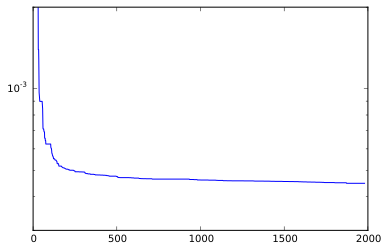

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(sorted(link_weights.values(), reverse=True))
ax = plt.gca()
ax.set_ylim((0.0003, 0.002))
ax.set_yscale('log')

In [15]:
def search(*terms):
    from IPython.display import HTML
    
    def get_matches(term):
        urls = set()
        for k in keywords.keys():
            if term in k:
                for url in keywords[k]:
                    urls.add(url)
        return urls
    
    result = get_matches(terms[0])
    for term in terms[1:]:
        result = result.intersect(get_matches[term])

    # sort by pagerank
    result = sorted(result, key = link_weights.get, reverse=True)
        
    urls_html = ['<a href="{0}" target="_blank">{0}</a> ({1:.6e})'.format(r, link_weights[r])
                 for r in result]
    return HTML('<br>'.join(urls_html))

Suche nach Seiten, die das Teilwort "mathemat" beinhalten:

In [16]:
search("bachelor")

In [17]:
len(keywords)

5388

10 zufällig gewählte Schlüsselwörter

In [18]:
random.sample(keywords.keys(), 10)

[u'ireland', u'gearbeitet', u'lise', u'christoph', u'enter', u'petra', u'16417', u'formulars', u'garderobepflicht', u'a008']